# Practical Machine Learning for Physicists
## Week 4 Exercise - Part 2


For both of these tasks we want you to implement autoencoder networks that:
- Train on randomly generated circles (using the circle_generator function below)
- Use 27x27 pixel images
- Use no more than 30,000 randomly generated samples (e.g. batchsize 30 and 1000 steps, or batchsize 1000 and 30 steps, or anywhere inbetween) in training the final networks for each task
- Use the mean_squared_error loss function
- Fulfil the network size requirement listed in the task (can be verifired using the print_layers function, after the network is partially trained)

### Task 1:
Implement any network design, but the bottleneck must contain no more than 9 neurons.

### Task 2:
Implement any network design, but the bottleneck must contain no more than 3 neurons.


#### Practicalities
You should use this notebook for your work and upload it to both Moodle and CoCalc. You are expected to use TensorFlow and Keras to complete these tasks. The notebook should be self-contained and able to be executed if necessary. Marks will be awarded for (roughly equally weighted):
- Overall notebook clarity (both in terms of good coding practice and coherent discussion)
- Task 1 performance (0.02 is a good target cost to do better than)
- Task 2 performance ( a good target here is left for the student to determine)


In [1]:
# Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import tensorflow as tf
from tensorflow import keras
import cv2

In [2]:
#A big messy function to do the training
# model -- our keras neural model autoencoder
# image_generator -- a function to generate random images for the training (see below for examples)
# img_size -- the size of our image in pixels
# batchsize -- the number of images to include in each training batch
# steps -- the number of steps taken in the training
#
# returns an array of the costs
def generate_and_train(model,image_generator,img_size,batchsize,steps):
   
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    #y_test=np.zeros([1,pixels,pixels,1])
    #y_test[:,:,:,0]=image_generator(1,x,y)
    
    #Now create the empty arrays for the images and cost
    y_in=np.zeros([batchsize,img_size,img_size,1])
    y_target=np.zeros([batchsize,img_size,img_size,1])
    cost=np.zeros(steps)
    
    #Loop through the steps, get a random batch of samples, train the model, repeat
    for k in range(steps):
        # produce samples:
        y_in[:,:,:,0]=image_generator(batchsize,x,y)
        y_target=np.copy(y_in) # autoencoder wants to reproduce its input!
        
        # do one training step on this batch of samples:
        cost[k]=model.train_on_batch(y_in,y_target)
    
    return cost,y_target

def get_test_image(image_generator,img_size):
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    y_test=np.zeros([1,img_size,img_size,1])
    y_test[:,:,:,0]=image_generator(1,x,y)
    return y_test

# A function to generate and plot a single test image and the output of our model
# only to be called after training the model
def plot_test_image(model,image_generator,img_size):
    #Get random test image
    y_test=get_test_image(image_generator,img_size)
    
    #Create the output image
    y_test_out=model.predict_on_batch(y_test)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(y_test[0,:,:,0],origin='lower')
    ax[0].set_title("Input")
    ax[1].imshow(y_test_out[0,:,:,0],origin='lower')
    ax[1].set_title("Output")
    
def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize,pixels,pixels,channels).
    After a call to the visualization routine, y_target will contain
    the last set of training images, so you could feed those in here.
    """
    layer_features=get_layer_activations(network,y_in)
    #print(layer_features)
    for idx,feature in enumerate(layer_features):
        s=np.shape(feature)
        print("Layer "+str(idx)+": "+str(s[1]*s[2]*s[3])+" neurons / ", s)

def get_layer_activation_extractor(network):
    #print(network.inputs)
    #for layer in network.layers:
    #    print(layer.output)
    return(keras.Model(inputs=network.inputs,
                            outputs=[layer.output for layer in network.layers]))

def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate 
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor=get_layer_activation_extractor(network)
    #print(extractor)
    layer_features = extractor(y_in)
    return layer_features
    

## Circle generator

Below we define the circle generator function

In [3]:
# A simple image generator that returns an array of batchsize images
# each image has a size of x * y pixels
# in this image each image has a randomly placed circle (and the circle is of random size)
def circle_generator(batchsize,x,y):
    R=np.random.uniform(size=batchsize)
    x0=np.random.uniform(size=batchsize,low=-1,high=1)
    y0=np.random.uniform(size=batchsize,low=-1,high=1)
    return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) )

#### Example Circle
Below, we can view an example of circles generated by the above function.

In [4]:
# Lets see an example
batchsize = 100
x = np.linspace(-1, 1, 27)
y = np.linspace(-1, 1, 27)
X, Y = np.meshgrid(x, y)
output = circle_generator(batchsize, X, Y)
x_train = output

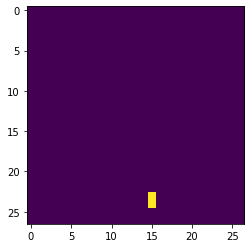

In [5]:
# Show the image
plt.imshow(x_train[0])

In [6]:
x_train[0].shape

(27, 27)

### Task 1: Implementing Bottleneck Autoencoder

In this first task, a bottleneck autoencoder model will be implemented. 

One requirement of task 1 is to have a bottleneck layer with 9 or fewer neurons.

In this task the aim is to reach a cost of 0.02 or lower.

First an example network was used from the source notebook. This one uses the sigmoid activation in each of the layers. There are also multiple convolutional layers. The mean square error was used as the cost function.

Below, we define a function to help plot and get the cost for the model.

In [7]:
def model_training(model, generator, steps, batch_size):

  '''
  Function to train the model and plot cost against steps
  Inputs: model (autoencoder model), generator, steps, batch_size
  Outputs: None (just the plots)
  '''
  # Get the cost + targets
  cost,y_target=generate_and_train(model,circle_generator,img_size=9*3,batchsize=batch_size,steps=steps)

  #Plot the cost
  plt.figure()
  plt.title('Cost vs Step')
  stepArray=np.arange(steps) 
  plt.plot(stepArray,cost,linewidth=3) 
  plt.xlabel("Step Number") 
  plt.ylabel("Cost")

  #And now when we look our model is probably doing a much better job of reproducing the image
  plot_test_image(model,generator,9*3)

  return cost

Next, the bottleneck encoder is implemented with 9 neurons on the bottleneck layer.

Another factor that was changed was the number of filters and the size of each filter. Increasing the number of filters on the convolutional layer increases the ability to learn new features from the data, but it also increases the number of parameters and complexity of the model.

It was also found that too many filters could lead to overfitting as well.

In [8]:
# Bottleneck Encoder

model2 = keras.models.Sequential()
model2.add(keras.layers.Conv2D(4, 3, input_shape=(27, 27, 1),
                               activation='relu', padding='same'))

model2.add(keras.layers.AveragePooling2D(pool_size=(3, 3), padding='same'))
model2.add(keras.layers.Conv2D(16, 3,
                               activation='relu', padding='same'))

# Bottleneck Layer
model2.add(keras.layers.AveragePooling2D(pool_size=(3, 3), padding='same')) 
model2.add(keras.layers.Conv2D(1,3,
               activation="relu",padding='same'))

model2.add(keras.layers.UpSampling2D(size=(3, 3))) 
model2.add(keras.layers.Conv2D(16, 3,
                               activation='relu', padding='same'))
model2.add(keras.layers.UpSampling2D(size=(3, 3))) # up
model2.add(keras.layers.Conv2D(16, 3,
                               activation='relu', padding='same'))
model2.add(keras.layers.Conv2D(1, 3, activation='linear', padding='same'))
model2.compile(loss='mean_squared_error', optimizer='adam')
model2.summary()

# Get the cost + targets
cost,y_target=generate_and_train(model2,circle_generator,img_size=9*3,batchsize=30,steps=10)

print_layers(model2, y_target)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 4)         40        
_________________________________________________________________
average_pooling2d (AveragePo (None, 9, 9, 4)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 16)          592       
_________________________________________________________________
average_pooling2d_1 (Average (None, 3, 3, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 1)           145       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 9, 9, 1)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 16)          1

The above model has around 3,400 parameters.

#### No. of neurons/filters
Different numbers of neurons/filters per convolutional layer was tested and it was found that beyond 6 filters, there was no significant decrease in cost beyond approximately 0.10. Sometimes the cost reached around 0.006, however this was not consistent when the model was re-run.

#### Pooling
Different pooling was also tested. It was found that pooling too much resulted in the image being too general and losing features. A smaller pool kept more of the details and also had a larger matrix.


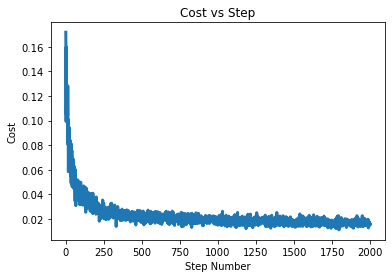

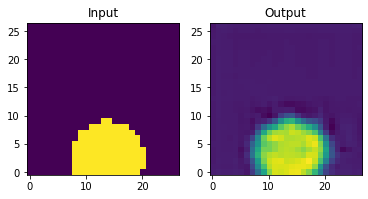

In [9]:
cost = model_training(model2, circle_generator, steps=2000, batch_size=15)

#### Steps and batch size
After experimenting with the steps and the batch size, it was found that steps of approximately 2000+ and batch sizes < 20 provided the lowest cost. As seen in the plot above, there is a sharp decline in cost at around 0 to 200 steps, after which the decline slows but also continues. 

#### Note
Another thing that was noticed was sometimes when the images were plotted, there was no circle to be seen, this was likely because the circle was generated outside of the frame.

In [10]:
print(f" Final Cost: {cost[-1]}")

 Final Cost: 0.015762902796268463


#### Cost
The final cost for this model is approximately  0.013, which is below the target cost of 0.02. However this would vary each time the code was run. Generally the final cost was approximately 0.011 to 0.017, which is below the target cost of 0.02

It was found that as the number of filters and filter size was increased, the cost would decrease, however the number of parameters would also increase. If the number of filters and filter size was increased too far however, there may also be overfitting. Thus there was a trade-off observed and a reasonable balance was found.

### Task 2
For task 2, an autoencoder will be implemented again but in this case the bottleneck layer must have 3 or fewer neurons.

To ensure 3 neurons on the bottleneck layer, we will have to make sure the shape is correct, which can be done by experimenting with the pooling and upsampling layers.

In [23]:
# Bottleneck Encoder
model2 = keras.models.Sequential()
model2.add(keras.layers.Conv2D(20, 10, input_shape=(27, 27, 1),
                               activation='relu', padding='same'))

model2.add(keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same'))
model2.add(keras.layers.Conv2D(4, 5,
                               activation='relu', padding='same'))
# Pooling to reduce neurons
model2.add(keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same')) 

model2.add(keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same')) 

model2.add(keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same')) 

model2.add(keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same')) 
model2.add(keras.layers.Conv2D(3, 3,
                               activation='relu', padding='same'))
model2.add(keras.layers.UpSampling2D(size=(3, 3))) 
model2.add(keras.layers.Conv2D(4, 5,
                               activation='relu', padding='same'))
# Increase neurons
model2.add(keras.layers.UpSampling2D(size=(3, 3))) # up
model2.add(keras.layers.UpSampling2D(size=(3, 3))) # up

model2.add(keras.layers.Conv2D(8, 13,
                               activation='relu', padding='same'))
model2.add(keras.layers.Conv2D(8, 13,
                               activation='relu', padding='same'))
model2.compile(loss='mean_squared_error', optimizer='adam')
model2.summary()

# Get the cost + targets
cost,y_target=generate_and_train(model2,circle_generator,img_size=9*3,batchsize=30,steps=10)
print_layers(model2, y_target)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 27, 27, 20)        2020      
_________________________________________________________________
average_pooling2d_22 (Averag (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 4)         2004      
_________________________________________________________________
average_pooling2d_23 (Averag (None, 7, 7, 4)           0         
_________________________________________________________________
average_pooling2d_24 (Averag (None, 4, 4, 4)           0         
_________________________________________________________________
average_pooling2d_25 (Averag (None, 2, 2, 4)           0         
_________________________________________________________________
average_pooling2d_26 (Averag (None, 1, 1, 4)          

The above model has approximately 20,000 parameters. It was found that many more filters and filter size was needed to even find a comparable cost as we have found in task 1. 

Layer 7 is the bottleneck layer, and above we can see this now has 3 neurons.

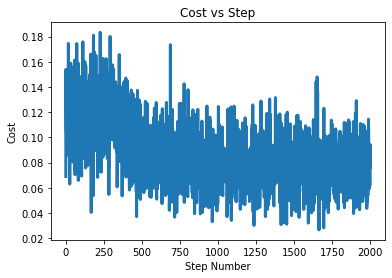

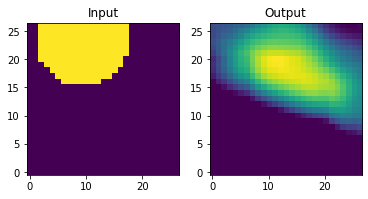

In [24]:
cost = model_training(model2, circle_generator, steps=2000, batch_size=10)

#### Cost and steps
Again, the optimal number of steps and batch size seemed to be approximately 2000 steps and 10-15 batch size. We observe a similar plot to the one in task 1, with the trend of exponential decay persisting.

In [25]:
print(f" Final Cost: {cost[-1]}")

 Final Cost: 0.06278263032436371


#### Cost
The final cost in this case was 0.063. We can also notice in the plot of cost against step that there is a lot more noise in the cost, with wide variations in the final cost. 

This cost seems to vary each time the code is run, but remains in a similar region of 0.03 to 0.07.

#### Note
Again, sometimes there is no output image shown, likely due to the same reason as before.
We also observe the output image is more faded

#### Define a target
Therefore, when defining a target cost, it may be useful to look at the range of final costs on the plot. It appears that the final cost ranges from around 0.03 to 0.06, therefore I would suggest this range would be a good target. 

If I was to give a specific number, we can take the average of 0.03 and 0.06, giving a target cost of 0.045.

### Conclusion

Task 1: In task 1, it was found that we can improve the final cost to approximately 0.01, which is almost half the original target.

Task 2: In task 2, it was found that the achievable final cost with 3 neurons in the bottleneck is quite a lot higher than we found in task 1. There is quite a lot more variation in the final cost each time the code is run - so we can define our target cost to be around 0.040 or the range 0.030 to 0.070.